In [1]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import pytensor
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [93]:
A = np.array([[-1, 0.6], [0, -1]])
C = np.array([0, 0.4])
A1, A2, A3, A4 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
C1, C2 = C[0], C[1]
kappa = 1.92   # Neural decay.
gamma = 0.41   # Autoregulation of blood flow.
alpha = 0.32   # Stiffness parameter (outflow = volume^(1/alpha))
E0 = 0.34      # Resting oxygen extraction fraction
tau = 2.66     # Transit time (seconds)
k1 = 7. * E0
k2 = 2.
k3 = 2. * E0 - 0.2
V0 = 0.02      # Resting blood volume fraction

theta_true = np.array([A1, A2, A3, A4, C1, C2, kappa, gamma, alpha, E0, tau, k1, k2, k3, V0])
my_var_names = ['A1', 'A2', 'A3', 'A4', 'C1', 'C2', 'kappa', 'gamma', 'alpha', 'E0', 'tau', 'k1', 'k2', 'k3', 'V0']

t0 = 0.0
tend = 200.0
dt = 0.1
ts = np.arange(t0, tend + dt, dt)
n_steps = len(ts)

num_node = 2
x0 = np.zeros(num_node)   # neural state
s0 = np.zeros(num_node)   # vasodilatory signal
f0 = np.ones(num_node)    # blood flow
v0 = np.ones(num_node)    # blood volume
q0 = np.ones(num_node)    # deoxyhemoglobin content

#t0 = np.ones(num_node)


init_state = np.concatenate([x0, s0, f0, v0, q0])  # shape: (5*num_node,)

In [95]:
A

array([[-1. ,  0.6],
       [ 0. , -1. ]])

In [97]:
def stim_boxcar_pytensor(t, onsets, durations, amplitudes):
    """Boxcar stimulus function compatible with PyTensor"""
    u_t = 0
    for i in range(len(onsets)):
        u_t += pt.switch(pt.and_(t >= onsets[i], t <= (onsets[i] + durations[i])), amplitudes[i], 0)
    return u_t

#u     = stim_boxcar_pytensor(np.arange(200), [0],[10],[1])

In [99]:
def model_scan_simulation(theta,  onsets, durations, amplitudes, num_node, dt=0.1):
    with pm.Model() as model:
        A1, A2, A3, A4, C1, C2, kappa, gamma, alpha, E0, tau, k1, k2, k3, V0 = theta

        def ode_update_function(t, state, A1, A2, A3, A4, C1, C2, kappa, gamma, alpha, E0, tau, k1, k2, k3, V0):
            
            x = state[0:num_node]
            s = state[num_node:2*num_node]
            f = state[2*num_node:3*num_node]
            v = state[3*num_node:4*num_node]
            q = state[4*num_node:5*num_node]
            
            stimulus = stim_boxcar_pytensor(t, onsets, durations, amplitudes)
            A_mat = pt.stack([[A1, A2], [A3, A4]])
            C_vec = pt.stack([C1, C2])
            #stimulus = 
            dx_dt = pt.dot(A_mat, x) + C_vec * stimulus
            new_x = x + dt * dx_dt

            # Hemodynamic state updates (using the Runge-Kutta method)
            s_k1 = x - kappa * s - gamma * (f - 1)
            f_k1 = s
            v_k1 = (1 / tau) * (f - v ** (1 / alpha))
            q_k1 =  (1 / tau) * (((f * (1 - (1 - E0) ** (1 / f))) / E0) - q * v ** (1 / alpha - 1))

            # Compute intermediate values (Euler method)
            s_a = s + s_k1 * dt
            f_a = f + f_k1 * dt
            v_a = v + v_k1 * dt
            q_a = q + q_k1 * dt

            # 2nd order increments (RK2 method)
            #s_k2 = x - kappa * s_a - gamma * (f_a - 1)
            #f_k2 = s_a
            #v_k2 = (1 / tau) * (f_a - v_a ** (1 / alpha))
            #q_k2 = (1 / tau) * (((f_a * (1 - (1 - E0) ** (1 / f_a))) / E0) - q_a * v_a ** (1 / alpha - 1))
#
            ## Update states using RK2
            #s_new = s + 0.5 * (s_k1 + s_k2) * dt
            #f_new = f + 0.5 * (f_k1 + f_k2) * dt
            #v_new = v + 0.5 * (v_k1 + v_k2) * dt
            #q_new = q + 0.5 * (q_k1 + q_k2) * dt
            #new_state = pt.concatenate([new_x, s_new, f_new, v_new, q_new])
            new_state = pt.concatenate([new_x, s_a, f_a, v_a, q_a])
            return new_state

        init_state_tensor = pt.as_tensor_variable(init_state)
        t_vals = pt.arange(n_steps, dtype="float64")
        result, updates = pytensor.scan(
            fn=ode_update_function,
            sequences=[t_vals],  
            outputs_info= [init_state_tensor],
            non_sequences=[A1, A2, A3, A4, C1, C2, kappa, gamma, alpha, E0, tau, k1, k2, k3, V0],
            n_steps=n_steps
        )

        f_result = result[:, 2*num_node:3*num_node]
        v_result = result[:, 3*num_node:4*num_node]
        q_result = result[:, 4*num_node:5*num_node]
        bold = V0 * (k1 * (1 - q_result) + k2 * (1 - q_result/v_result) + k3 * (1 - v_result))

        

        # Save the computed BOLD signal as a deterministic variable.
        pm.Deterministic("bold",  bold)
        
    return model


In [102]:
theta_true

array([-1.  ,  0.6 ,  0.  , -1.  ,  0.  ,  0.4 ,  1.92,  0.41,  0.32,
        0.34,  2.66,  2.38,  2.  ,  0.48,  0.02])

In [104]:
# Example of creating the model:
model = model_scan_simulation(theta_true,[0],[20],[10], num_node, dt=0.05)

In [106]:
model

bold ~ Deterministic(f())

Sampling: []


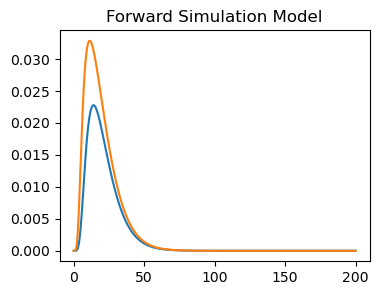

In [108]:

fig, ax = plt.subplots(figsize=(4, 3))
with model:
    # Sample prior predictive to get the BOLD signal
    simul = pm.sample_prior_predictive(1).prior.bold[0][0].values
    ax.plot(ts, simul)
    #bold_signal = prior_predictive["BOLD"][0]  # Extract BOLD signal from the sampled prior

ax.set_title("Forward Simulation Model");

In [110]:
data = simul[:,1]

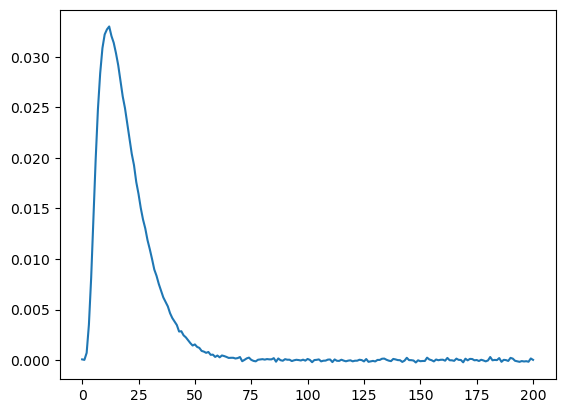

In [112]:
ds=10
ts_obs=ts[::ds]
xpy_ds=data[::ds].flatten()
sigma_true=0.0001
x_noise = np.random.normal(loc=0, scale=sigma_true, size=xpy_ds.shape[0])
xpy_obs = xpy_ds + x_noise

plt.plot(np.arange(201), xpy_obs)

In [114]:
import pandas as pd
# fmt: off
data = pd.DataFrame(dict(
    ts_obs = ts_obs,
    xpy_obs = xpy_obs, ds=ds))
data.head()

,ts_obs,xpy_obs,ds
0,0.0,0.000071,10
1,1.0,0.000022,10
2,2.0,0.000716,10
3,3.0,0.003501,10
4,4.0,0.008130,10
